# EDA Project

### 0. Preparations of the Data
#### First steps in DBeaver 
  * modify the data
  * Identify the compound key: `id` == `house_id`
  * left joined with the `id` in `king_county_house_details alias kchd` and `house_id` in `king_county_house_sales alias kchs`

In [3]:
# Import and fetch the joined EDA data to get a pandas dataframe
# Import all the tools you want to use in this notebook

from sqlalchemy import create_engine
import os
from dotenv import load_dotenv
import pandas as pd


#read the database string from the .env
load_dotenv()

DB_STRING = os.getenv('DB_STRING')

db = create_engine(DB_STRING)

#import the data to a pandas dataframe (IMPORTANT to put the 'eda.')
query_string = """SELECT
	kchs.date,
	kchs.price,
	kchs.id AS sale_id,
	kchd.id AS house_id,
	kchd.bedrooms,
	kchd.bathrooms,
	kchd.sqft_living,
	kchd.sqft_lot,
	kchd.floors,
	kchd.waterfront,
	kchd.view,
	kchd.condition,
	kchd.grade,
	kchd.sqft_above,
	kchd.sqft_basement,
	kchd.yr_built,
	kchd.yr_renovated,
	kchd.zipcode,
	kchd.lat,
	kchd.long,
	kchd.sqft_living15,
	kchd.sqft_lot15
FROM
	eda.king_county_house_sales kchs
LEFT JOIN eda.king_county_house_details kchd ON
	kchd.id = kchs.house_id ;"""
df = pd.read_sql(query_string, db)

# export the data to a csv-file
df.to_csv('eda-joined.csv',index=False)

#import the data from a csv-file and clarify date column to date format
df = pd.read_csv('eda-joined.csv', parse_dates=['date'])


## 1. Understanding the Data

#### Exploratory Data Analysis
1. What is the purpose of the dataset?
2. What are the potential issues with the data (e.g., duplicates, typos)?
3. How prevalent are missing values?
4. What are the central tendencies and spread of data?
5. How can the data be visually represented?
6. Are there extreme values that may impact analysis?
7. How do variables relate to each other?
8. Are there transformations to improve analysis?


##### What is the purpose of the dataset?

In [75]:
# Play with the data overview using following functions 

df.head()

# (df.info(), df.describe(), df.shape, ...)

,date,price,sale_id,house_id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,sqft_above,is_renovated,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2014-10-13,221900.0,1,7129300520,3.0,1.00,1180.0,5650.0,1.0,False,...,1180.0,False,0.0,1955,1955,98178,47.5112,-122.257,1340.0,5650.0
1,2014-12-09,538000.0,2,6414100192,3.0,2.25,2570.0,7242.0,2.0,False,...,2170.0,True,400.0,1951,1991,98125,47.7210,-122.319,1690.0,7639.0
2,2015-02-25,180000.0,3,5631500400,2.0,1.00,770.0,10000.0,1.0,False,...,770.0,False,0.0,1933,1933,98028,47.7379,-122.233,2720.0,8062.0
3,2014-12-09,604000.0,4,2487200875,4.0,3.00,1960.0,5000.0,1.0,False,...,1050.0,False,910.0,1965,1965,98136,47.5208,-122.393,1360.0,5000.0
4,2015-02-18,510000.0,5,1954400510,3.0,2.00,1680.0,8080.0,1.0,False,...,1680.0,False,0.0,1987,1987,98074,47.6168,-122.045,1800.0,7503.0


##### What are the central tendencies and spread of data?

In [76]:
# Look at specific columns to get more interesting insights of data

# price (can be assumed to be in us $)
df['price'].max() # 7.700.000
df['price'].min() # 78.000
df['price'].describe()

# bedrooms - how many bedrooms does the house have
df['bedrooms'].describe() # 1 to 33 bedrooms
df['bedrooms'].unique() # no half bedrooms

# sqft_living - footage of the home
df['sqft_living'].describe() # might be interesting to see what is the difference between sqft_living and sqft_above

# waterfront - access to the waterfront or not
df['waterfront'].unique() # 1.0 = waterfront YES
df[df['waterfront'] == 1.0].shape # 146 with waterfront access

#view - if house has been viewed or not
#df['view'].describe() # 1 to 4 rating the view (?)
#df[(df['view'] == 1.0) & ['price']].describe() # a 1.0 view could be connected to a higher price

# condition - from 1 == poor to 5 == very good
df['condition'].describe() # 1 to 5 rating the condition
df[(df['condition'] == 1.0) & ['price']].describe() # trying to relate the condition and price

# grade (building grade) - from 1 == e.g. cabin to 13 == e.g. custom build mansion
# df['grade'].describe() # grade from 1 to 13, could mean the best is 13
# df[(df['grade'] == 13.0) & ['price']].describe()

#sqft_above - Square footage of house apart from basement
df['sqft_above'].describe()
# biggest sqft = 9140 =~ 850qm and smallest = 370 sqft =~ 34qm

# sqft_basement - Square footage of the basement
df['sqft_basement'].describe()
# there are more than 50% houses without a basement
# might be interesting to see relation to the yr_built

# yr_built - Built Year
df['yr_built'].describe()
# newest house from 2015 which is where the data is from according from column `date`
# oldest house from 1900

# yr_renovated - Year when house was renovated
df['yr_renovated'].describe() # most houses were not renovated
df['yr_renovated'].unique() # maybe add a column 

# zipcode - zip
df['zipcode'].value_counts() # most houses in zipcode 98103
df['zipcode'].nunique() # how many different zipcodes are included in the data
df['zipcode'].unique() # no invalid zipcode data


# lat & long - Latitude coordinate and long - Longitude coordinate
df[['lat', 'long']].describe() # see the relation of latitude and longitude
# all are in king county, WA, USA


# sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors
df['sqft_living15'].describe() # how big are the houses from the neighbors

# sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors
df['sqft_lot15'].describe() # biggest lot from the neighbors is 871.200 sqft
# smallest house is 651 sqft big


# in order to execute one of the above codes, take and copy them into the print statement below
df['sqft_living'].describe()


count    21597.000000
mean      2080.321850
std        918.106125
min        370.000000
25%       1430.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64

##### How prevalent are missing values?

In [86]:
# inspecting missing data

df.isnull().sum() # only missing data in columns 'waterfront', 'view', 'sqft_basement', 'yr_renovated'

# take the columns independently again to inspect missing values

# waterfront 
df['waterfront'].unique() # for easier analysis NaN value will be assumed as no waterfront

# view including other columns will be dropped as it is irrelevelant
# df.drop(['view', 'date', 'sale_id', "floors", "bathrooms"], axis=1) # after dropping once, it will show you an error because columns do no exist anymore
df.drop(["grade"],axis=1,inplace=True)

#sqft_basement
df['sqft_basement'].unique() #for easier analysis NaN value will be assumed as no basement

# yr_renovated
df['yr_renovated'] #for easier analysis NaN value will be assumed as no renovation inplace



0        1955
1        1991
2        1933
3        1965
4        1987
         ... 
21592    2009
21593    2014
21594    2009
21595    2004
21596    2008
Name: yr_renovated, Length: 21597, dtype: int64

# 2. Research Questions and Hypothesis Generation

Following relations may be interesting to check out: 
* The columns `sqft_basement` and `sqft_above` - are they related and whats the relation between them?
* Are new houses more likely to not have a basement (`yr_built` and `sqft_basement`-relation)?
* When was a house most likely to be renovated (beginning from which year)?
* Is a house built in the same year as an old house renovated in that year more worth than the old house itself?

### Insight Hyptheses

#### Based on the Research Questions I can build following Hypotheses:
1. New houses are less likely to have basements.
2. Since houses with waterfront access are rare they are more expensive than houses without waterfront access with the same criteria.
3. A house that is renovated in 1990 is more worth than a house build in 1990.

### Client Hypotheses

The client to be chosen is: 

| Name                | client | Characteristics                                                                                                                                                                 |
| ------------------- | ----------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Larry Sanders       | Buyer       | Waterfront , limited budget, nice & isolated but central neighborhood without kids (but got some of his own, just doesn't want his kids to play with other kids .. because of germs) |

**My client is Larry Sanders.**

* Larry Sanders wants: 
  * to *buy* a house on the Waterfront (only houses with waterfront access are important in that data)
  * has limited budget (define = limited budget)
  * central, but isolated and quiet (look for zip codes that are considered central , define = central)
  * no kids as neighbors (prefer houses with low `sqft_living15` because that could mean no kids)

Hypotheses:
1. All houses with waterfront access are expensive and require high budget.
2. All waterfront houses are on the countryside rather than central.
3. Waterfront houses are big enough to be isolated from neighbors in any kind.



# 3. Cleaning the data

In [6]:
import numpy as np
import math

#For Data Cleaning inspect following:

# clean waterfront column
df["waterfront"].replace(np.nan, 0, inplace=True)

# change column `waterfront` into boolean True if in '1.0'
df["waterfront"].replace(1, True, inplace=True)
df["waterfront"].replace(0, False, inplace=True)


# clean column `yr_renovated` as it has values like '19100.0' and NaN
df['yr_renovated'] = df['yr_renovated'].replace(0, np.nan)
df['yr_renovated'] = df['yr_built'].where(df['yr_renovated'].isna(), other=df['yr_renovated'])
df['yr_renovated'] = df['yr_renovated'].astype('int')

def adjust_year(value):
    digits = int(math.log10(value)) + 1
    dim = digits - 4
    result = int(value / 10**dim)
    return result
df['yr_renovated'] = df['yr_renovated'].apply(adjust_year)


# add new column `is_renovated` - True or False, if the same year built as renovated == False, if different years == True
df['is_renovated'] = np.where(df['yr_built'] == df['yr_renovated'],
                                                    False, True)

#move column next to yr_renovated
column_to_move = df.pop('is_renovated')
df.insert(14, 'is_renovated', column_to_move)


# clean sqft_basement column
df["sqft_basement"].replace(np.nan, 0, inplace=True)


# add new column `has_basement`- True or False if `sqft_basement` is not in 0 or empty
df['has_basement'] = np.where(df['sqft_basement'] != 0,
                                                    True, False)
df.pop('has_basement')
df.insert(12, 'has_basement', column_to_move)


# drop duplicates = > didn't drop any duplicates
df_without_duplicates = df.drop_duplicates()

df_without_duplicates.head()



# Dropped Data
# from the data were dropped the columns: "date", "view", "sale_id", "floors", "bathrooms", "grade"



,date,price,sale_id,house_id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,sqft_above,is_renovated,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2014-10-13,221900.0,1,7129300520,3.0,1.00,1180.0,5650.0,1.0,False,...,1180.0,False,0.0,1955,1955,98178,47.5112,-122.257,1340.0,5650.0
1,2014-12-09,538000.0,2,6414100192,3.0,2.25,2570.0,7242.0,2.0,False,...,2170.0,True,400.0,1951,1991,98125,47.7210,-122.319,1690.0,7639.0
2,2015-02-25,180000.0,3,5631500400,2.0,1.00,770.0,10000.0,1.0,False,...,770.0,False,0.0,1933,1933,98028,47.7379,-122.233,2720.0,8062.0
3,2014-12-09,604000.0,4,2487200875,4.0,3.00,1960.0,5000.0,1.0,False,...,1050.0,False,910.0,1965,1965,98136,47.5208,-122.393,1360.0,5000.0
4,2015-02-18,510000.0,5,1954400510,3.0,2.00,1680.0,8080.0,1.0,False,...,1680.0,False,0.0,1987,1987,98074,47.6168,-122.045,1800.0,7503.0


# 4. Relationships in the Data

Let's have a look on a couple insights of the data.

##### How do variables relate to each other?

[Text(0.5, 1.0, 'Pearson Correlation of numerical values')]

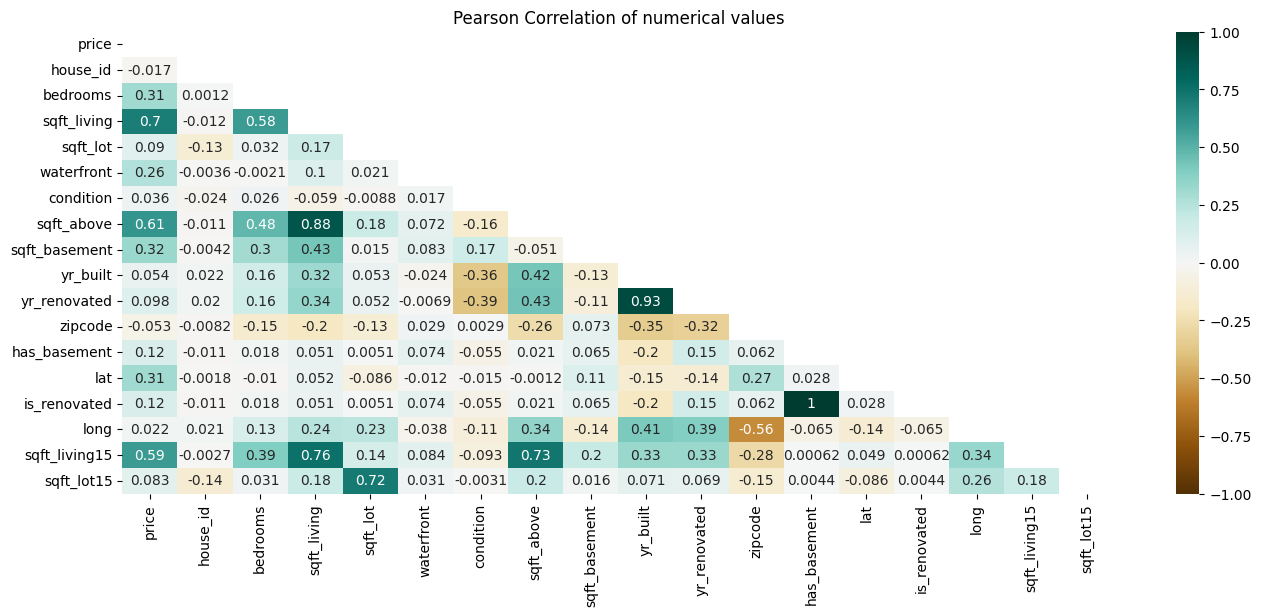

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(16, 6))

corr = df.corr(method='pearson', numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr,
            mask=mask,
            vmin=-1, vmax=1,
            annot=True,
            cmap='BrBG',
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values).set(title='Pearson Correlation of numerical values')

#### Insight Hypotheses

##### Hypthesis 1

New houses are less likely to have basements.


Text(0.5, 0, 'Basement')

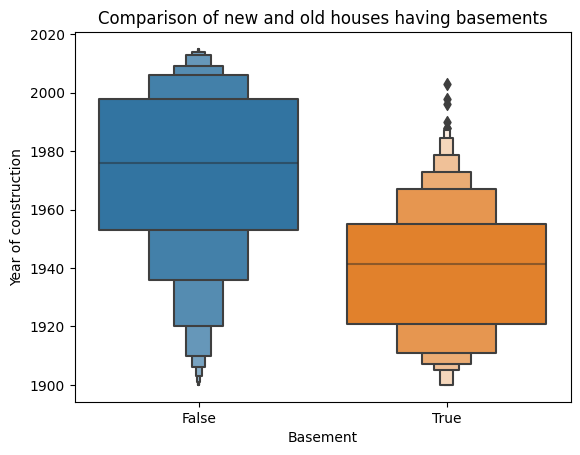

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = sns.boxenplot(y= 'yr_built', x='has_basement', data=df)


plt.title("Comparison of new and old houses having basements")
plt.ylabel('Year of construction')
plt.xlabel('Basement')

* We can clearly see that the houses older than 1960 are more likely to have a basement than the houses built after 1960.
*  The blue boxes getting smaller closer to today is because in general the count of the modern houses is lower.

##### Hypthesis 2

Since houses with waterfront access are rare they are more expensive than houses without waterfront access with the same criteria.


Text(0.5, 1.0, 'Relationship of price of the house and water access with houses having the same criteria')

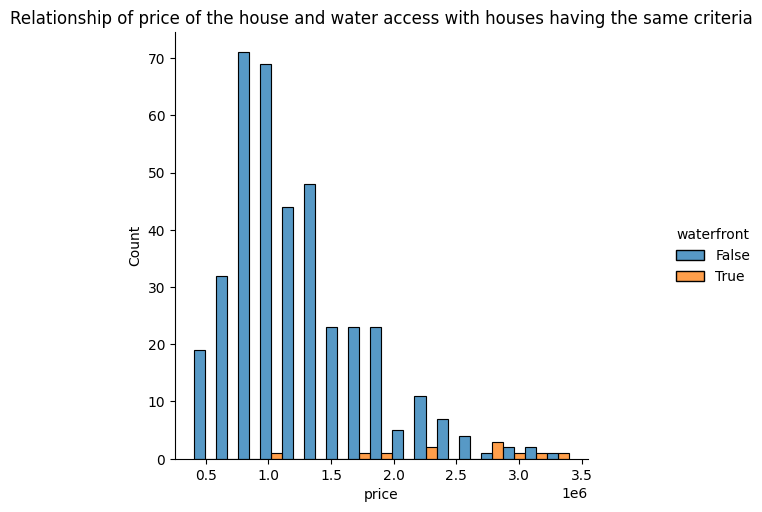

In [32]:
# modify the data so that only same criteria is compared
# especially take criteria that has high correlation to the price, e.g. sqft_living and bedrooms

df_criteria = df.query("bedrooms >= 3 and bedrooms <=5 and sqft_living >= 4000 and sqft_living <= 4500 ")

# show the boxplot
fig = sns.displot(df_criteria, x= "price", hue="waterfront", multiple="dodge")

#tried to modify the x axis labels, didn't work


plt.title("Relationship of price of the house and water access with houses having the same criteria")


* We can see that in general the number of houses with waterfront access ("waterfront houses") is low. 
* We can also see waterfront houses are generally more expensive when they have the same criteria. 
* We cannot say it is because they are rare. 

##### Hypthesis 3

A house that is renovated in 1990 is more worth than a house built in 1990.

In [2]:
# modify the data to show me any building renovated in 1990 or built in 1990, but distinguish between is renovated or not
# df_worth = df(df['yr_built'] == df['yr_renovated'])

# df_worth = df.[(df["yr_built"] == 1990) or (df[yr_renovated == 1990 and ")


sns.barplot(df, x="yr_built", y="is_renovated")

plt.title("Worth of a house renovated vs a house built in 1990 ")


NameError: name 'sns' is not defined

#### More Insights 

Geograhically looking at longitude and latitude given in the data.

In [27]:
# plot density mapbox for geographical insight

import plotly.express as px

fig = px.density_mapbox(df, lat='lat', lon='long', radius=2, mapbox_style="open-street-map")

fig.show()

Looking at the geographical perspective of the data:

* We can see the highest density of house north of the city center of Seattle
* We can also see that there are no houses listed in the CBD of Seattle, assuming that there are mainly business buildings or tourist attractions
* Also it is clear that the data includes houses on the Vashon Island which can be only reached by ferry from Seattle downtown



In [78]:
# Only show the waterfront objects

fig = px.density_mapbox(df[df['waterfront'] == 1.0], lat='lat', lon='long', radius=2, mapbox_style="open-street-map")

fig.update_layout(title="Location of the Waterfront Lots")

fig.show()


#### Client

##### Hypothesis 1

All houses with waterfront access are expensive and require high budget.

In [16]:
import plotly.express as px 
 
fig = px.scatter(df, x='waterfront', y='price', color='waterfront',
                 labels={'waterfront': 'Waterfront Access', 'price': 'House Price'},
                 title='Relationship Between Waterfront Access and House Price')

fig.update_layout(
    xaxis=dict(title='Waterfront Access'),
    yaxis=dict(title='House Price'),
    showlegend=True)

fig.show()

First of all, we can generally say, that there are houses with and without waterfront access that are expensive.


In [29]:
df_waterfront = df[df["waterfront"] == True]

fig = px.box(df_waterfront, y='price',
              points="all", 
              title='Price Range of Waterfront Houses', 
              labels={'price': 'Price'})

fig.show()

Seeing now the price range of all the houses with waterfront access, we can see that the main part of the houses have a price range from 825k $US and 2.3M $US. 

There are also waterfront houses that are between 285k and 500k and so defined do not require high budget.

Assuming that 500k $US for a house is limited budget for a Dad with kids (that are still playing) who could be in his 30s to 40s.

Let's have a look at all the houses that are in the limited budget range.



In [36]:
limited_budget_waterfront = df_waterfront[df_waterfront["price"] <= 500000]

fig = px.scatter(limited_budget_waterfront, x='long', y='lat', color='price',
                 size='sqft_living', hover_data=['zipcode'],
                 title='Houses with Limited Budget',
                 labels={'Price': 'House Price', 'Sqft_living': 'Living Area'})

fig.show()

##### Hypothesis 2

All waterfront houses are on the countryside rather than central.

Define the central location. Therefore, I took the zipcodes of King County.

< image src="/ https://aqua.kingcounty.gov/gis/web/VMC/boundaries/zipcodes/zipcodes.pdf /"


 Looking at an image of the zip code. All the zipcodes in the red area are central.

In [63]:
# create a dataframe with limited budget, waterfront access and central location
central_waterfront_budget = limited_budget_waterfront.query("zipcode <= 98144 and zipcode >= 98105") 

fig = px.scatter(central_waterfront_budget, x='price', y=('zipcode'),
                 title='Central Zip Codes with prices in King County, WA, USA',
                 labels={'Central': 'Central Zip Code'})

fig.show()

# no data with this code

There is no waterfront lot in central location with limited budget (<=500k $US).

In [64]:
# exclude the budget and only take waterfront access and central zipcode
df_central = df.query("zipcode <= 98144 and zipcode >= 98105 and waterfront == True")

fig = px.scatter(df_central, x='price', y=str('zipcode'),
                 title='Central Zip Codes with prices in King County, WA, USA',
                 labels={'Central': 'Central Zip Code'})

# Customize the color scale
fig.update_traces(marker=dict(size=12),
                  selector=dict(type='scatter', mode='markers'))

fig.show()


In the chart we can see that the lowest price for a house in a central zipcode with waterfront access is worth 658k $US.

Larry Sanders has to spend at least 658k $US with his criteria.

##### Hypothesis 3

Waterfront houses are big enough to be isolated from neighbors in any kind.

To find out if the neighbors do not have any kids, the closest asumption would be that the `sqft_living15` is low. 

In [65]:
#take central location and waterfront houses and show the 

fig = px.scatter(df_central, x='sqft_living15', y='price', title=f'Sqft Living Comparison of the neighbors in central location', color="price")

fig.update_traces(marker=dict(size=12),
                  selector=dict(type='scatter', mode='markers'))

# Rename xaxis
fig.update_xaxes(title_text='Average Square Feet of the Living Area of the 15 closest living Neighbors')

fig.show()

We can see that the neighbors of the houses with waterfront access in central location do not have small living spaces. If we take the 658k $US house we can see the square feet of the living area of the 15 closest neighbors is  1820 sqt which equals to ~ 170qm.

You could now continue looking into the data to find the perfect fit for Larry Sanders. Here this will be too time consuming.

Just to close the hypthesis let's shortly look into the lot size of the given houses.

In [70]:
fig = px.scatter(df_central, x='sqft_lot', y='price', title=f'Sqft Lot Comparison of the houses in central location')

fig.update_traces(marker=dict(size=12),
                  selector=dict(type='scatter', mode='markers'))

# Rename xaxis
fig.update_xaxes(title_text='Square Feet of the Lot of the Houses')

fig.show()

The smallest lot of the given houses would be 14.244 sq ft which equals to 1323 qm. 
This is a pretty big lot, which means waterfront houses are big enough too isolate from your neighbors.

PS: I didn't check all waterfront houses because I just wanted to investigate the relevant data.

## Conclusion

If we are looking at all the criteria that Larry Sanders has given, there will be no perfect fit for him from the houses listed. 

Never the less, I would pick for him the house with house_id *7936500221* that costs $US 658.000 as it fulfills the criterias being central, having a waterfront, the least biggest houses close from the lot and a huge lot itself for the kids to play on by themselves.

In [71]:
df_central[df_central['price']== 658000]

,date,price,sale_id,house_id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,sqft_above,is_renovated,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15357,2015-01-14,658000.0,15358,7936500221,2.0,1.0,1010.0,14244.0,1.0,True,...,1010.0,False,0.0,1926,1926,98136,47.5476,-122.399,1820.0,15792.0
